# ER graph

In [1]:
# comparison data = https://zenodo.org/records/13382427

In [2]:
NODE_NUM = 100
CONNECTION_PROB = 0.7 # change this
HUB_PROB = 0.2 # change this
RAND_SEED = 4403

In [3]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate, savefig

# Set the random seed so the notebook
# produces the same results every time.
np.random.seed(17)

In [5]:
# make a directory for figures
!mkdir -p figs

In [6]:
# node colors for drawing networks
colors = sns.color_palette('pastel', 5)
#sns.palplot(colors)
sns.set_palette(colors)

## Implementation

### Basic ER graph

In [7]:
random_graph = nx.erdos_renyi_graph(n=NODE_NUM, p=CONNECTION_PROB, seed=RAND_SEED)
len(random_graph.edges())

3467

Draw the graph

In [8]:
# %matplotlib notebook

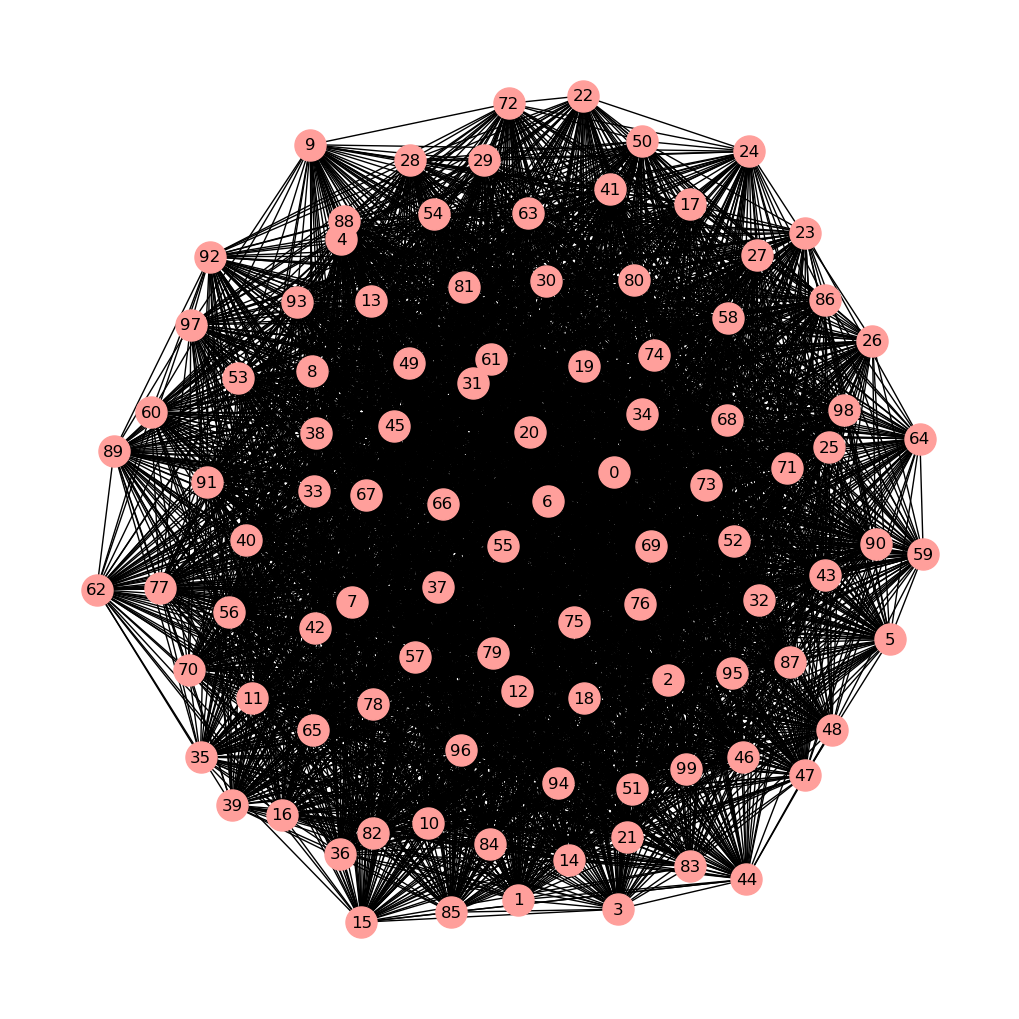

In [9]:
plt.figure(figsize=(10, 10))
nx.draw(random_graph,
        node_color='C3',
        node_size=500,
        with_labels=True)
plt.show()

Actual represenation: few highly connected cliques + hubs that have even more connections

In [10]:
def flip(p):
    return np.random.random() < p

def all_pairs(nodes):
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

def random_pairs(nodes, p):
    for edge in all_pairs(nodes):
        if flip(p):
            yield edge

In [11]:
def hub_pairs(nodes, num_hubs):
    if num_hubs >= len(nodes):
        raise ValueError("Number of hubs must be less than total number of nodes.")

    hubs = nodes[:num_hubs]
    leaves = nodes[num_hubs:]

    connections = []

    for i, leaf in enumerate(leaves):
        hub = hubs[i % num_hubs]
        connections.append((hub, leaf))

    return connections

In [12]:
def make_random_hub_graph(n, p, hn, hcp=1):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    hub_nodes = range(hn)
    G.add_edges_from(random_pairs(hub_nodes, p)) # random graph for hubs
    G.add_edges_from(hub_pairs(nodes, hn)) # attaching leaves to hubs
    return G

In [41]:
# 25 hubs with each 4 nodes
np.random.seed(RAND_SEED)

random_graph2 = make_random_hub_graph(NODE_NUM, CONNECTION_PROB, 25)

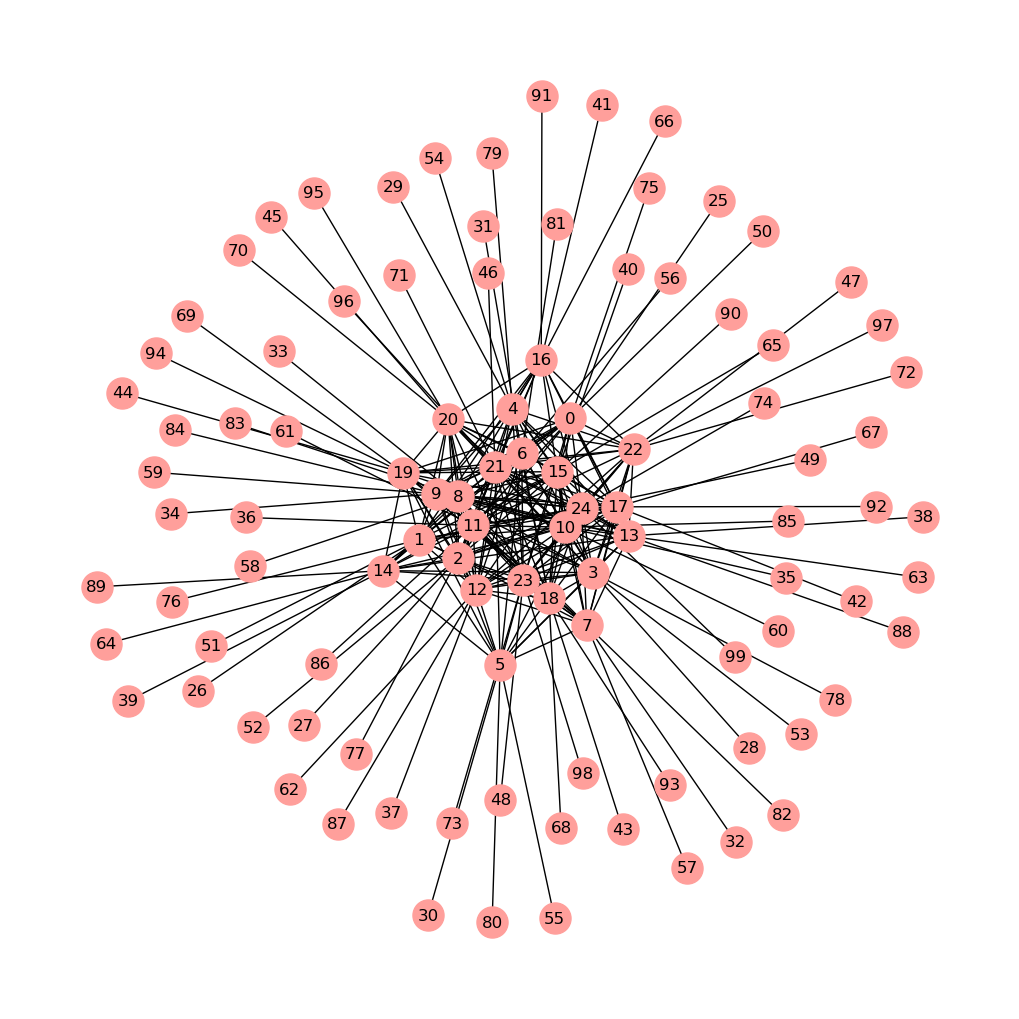

In [42]:
plt.figure(figsize=(10, 10))
nx.draw(random_graph2,
        node_color='C3',
        node_size=500,
        with_labels=True)
plt.show()

## Heurisitics

In [15]:
from matplotlib.animation import FuncAnimation

Using the poission method to estimate the likelihood of estimation + graph

1. Using the ER graph

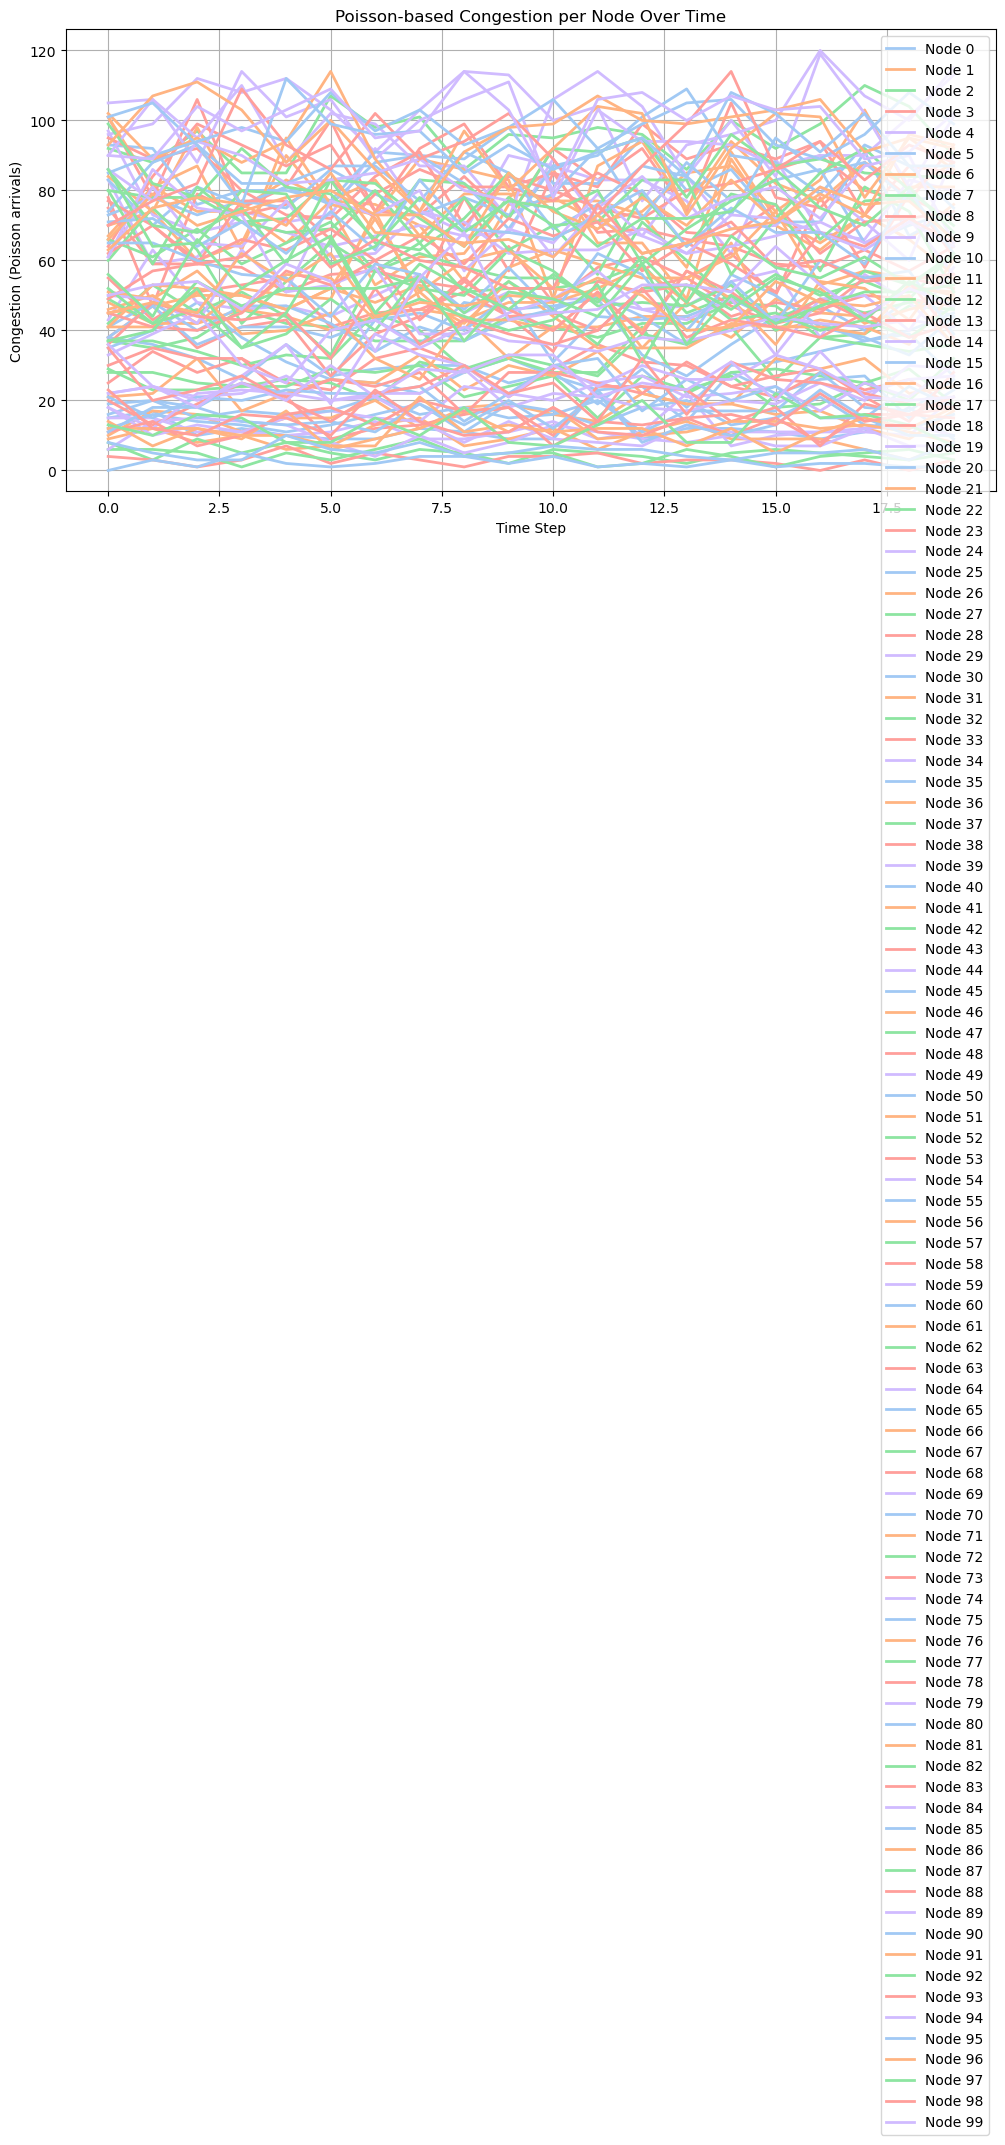

In [38]:
# Define time steps and Poisson rates
np.random.seed(RAND_SEED)
time_steps = 20
lambdas = np.random.uniform(1, NODE_NUM, size=NODE_NUM)

# Simulate Poisson congestion data
congestion_data = np.array([
    np.random.poisson(lam=lambdas[node], size=time_steps)
    for node in range(NODE_NUM)
])

# Plot congestion over time for each node
plt.figure(figsize=(12, 6))
for node in range(NODE_NUM):
    plt.plot(range(time_steps), congestion_data[node], label=f'Node {node}')
plt.xlabel('Time Step')
plt.ylabel('Congestion (Poisson arrivals)')
plt.title('Poisson-based Congestion per Node Over Time')
plt.legend()
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


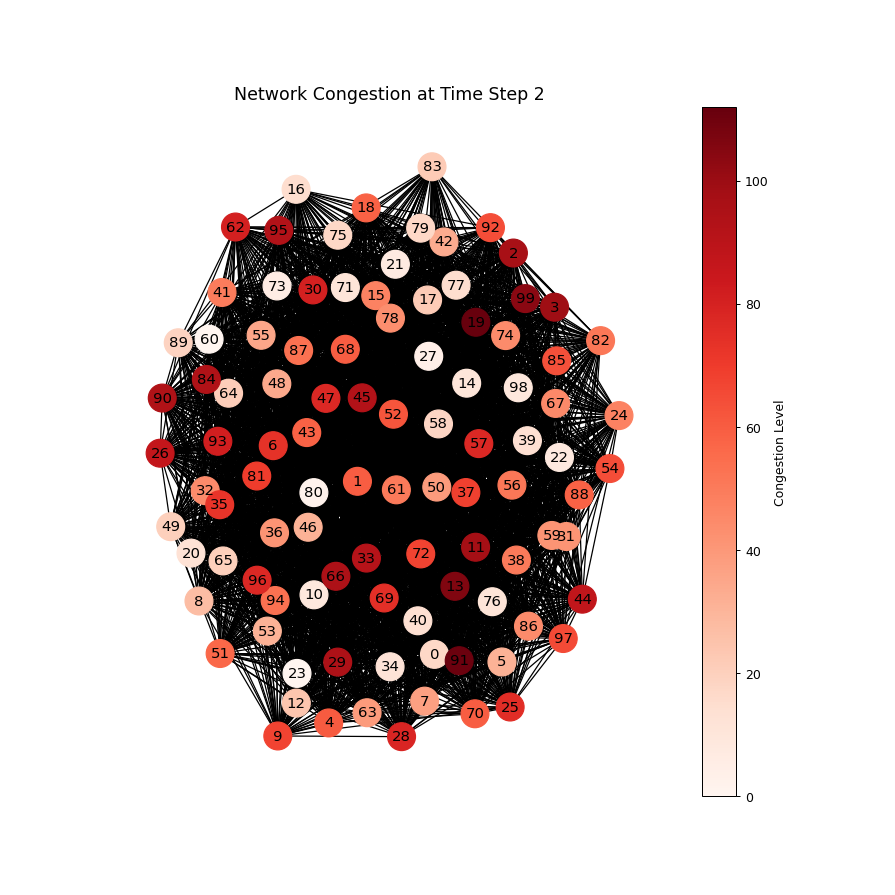

In [62]:
# Setup animation
fig, ax = plt.subplots(figsize=(10, 10))

sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=np.max(congestion_data)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Congestion Level')

# Animation update function
def update(frame):
    ax.clear()
    ax.axis('off')
    ax.set_title(f"Network Congestion at Time Step {frame}", fontsize=14)
    pos = nx.circular_layout(random_graph)
    node_colors = congestion_data[:, frame]
    nx.draw(random_graph, with_labels=True, node_color=node_colors, cmap='Reds', node_size=500, ax=ax)
    
    # Update colorbar normalization
    sm.set_clim(vmin=0, vmax=np.max(congestion_data[:, frame]))
    sm.set_array(node_colors)

# Run animation
anim = FuncAnimation(fig, update, frames=time_steps, interval=500)

2. Using the modified ER graph

<IPython.core.display.Javascript object>


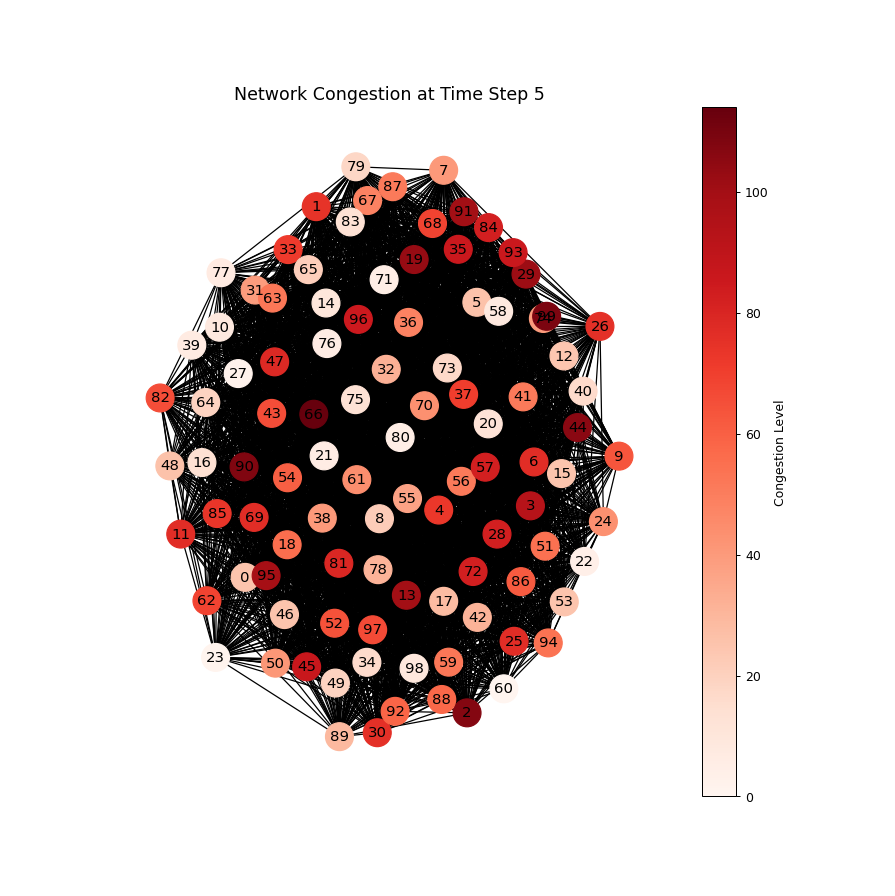

In [63]:
# Setup animation
fig, ax = plt.subplots(figsize=(10, 10))

sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=np.max(congestion_data)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Congestion Level')

# Animation update function
def update(frame):
    ax.clear()
    ax.axis('off')
    ax.set_title(f"Network Congestion at Time Step {frame}", fontsize=14)
    
    node_colors = congestion_data[:, frame]
    nx.draw(random_graph2, with_labels=True, node_color=node_colors, cmap='Reds', node_size=500, ax=ax)
    
    # Update colorbar normalization
    sm.set_clim(vmin=0, vmax=np.max(congestion_data[:, frame]))
    sm.set_array(node_colors)

# Run animation
anim = FuncAnimation(fig, update, frames=time_steps, interval=500)

Timestep of bytes